In [117]:
import numpy as np
import os
from CoPhaser import utils
from CoPhaser import plotting
import sys

sys.path.insert(0, "../set_up")  # add set_up path to search list

import plot_helpers
import constants

from scipy.stats import pearsonr
from scipy.sparse import csr_matrix, hstack, vstack

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

import anndata
import scanpy as sc
import pickle
import pandas as pd

In [118]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
DATA_FOLDER_ALL_GENES = "../figure_2/data"
DATA_FOLDER = "data/"
SCRNASEQ_DATA_FOLDER = "../../../data/"

height_ratios_scaling: [1, 1, 1, 1]


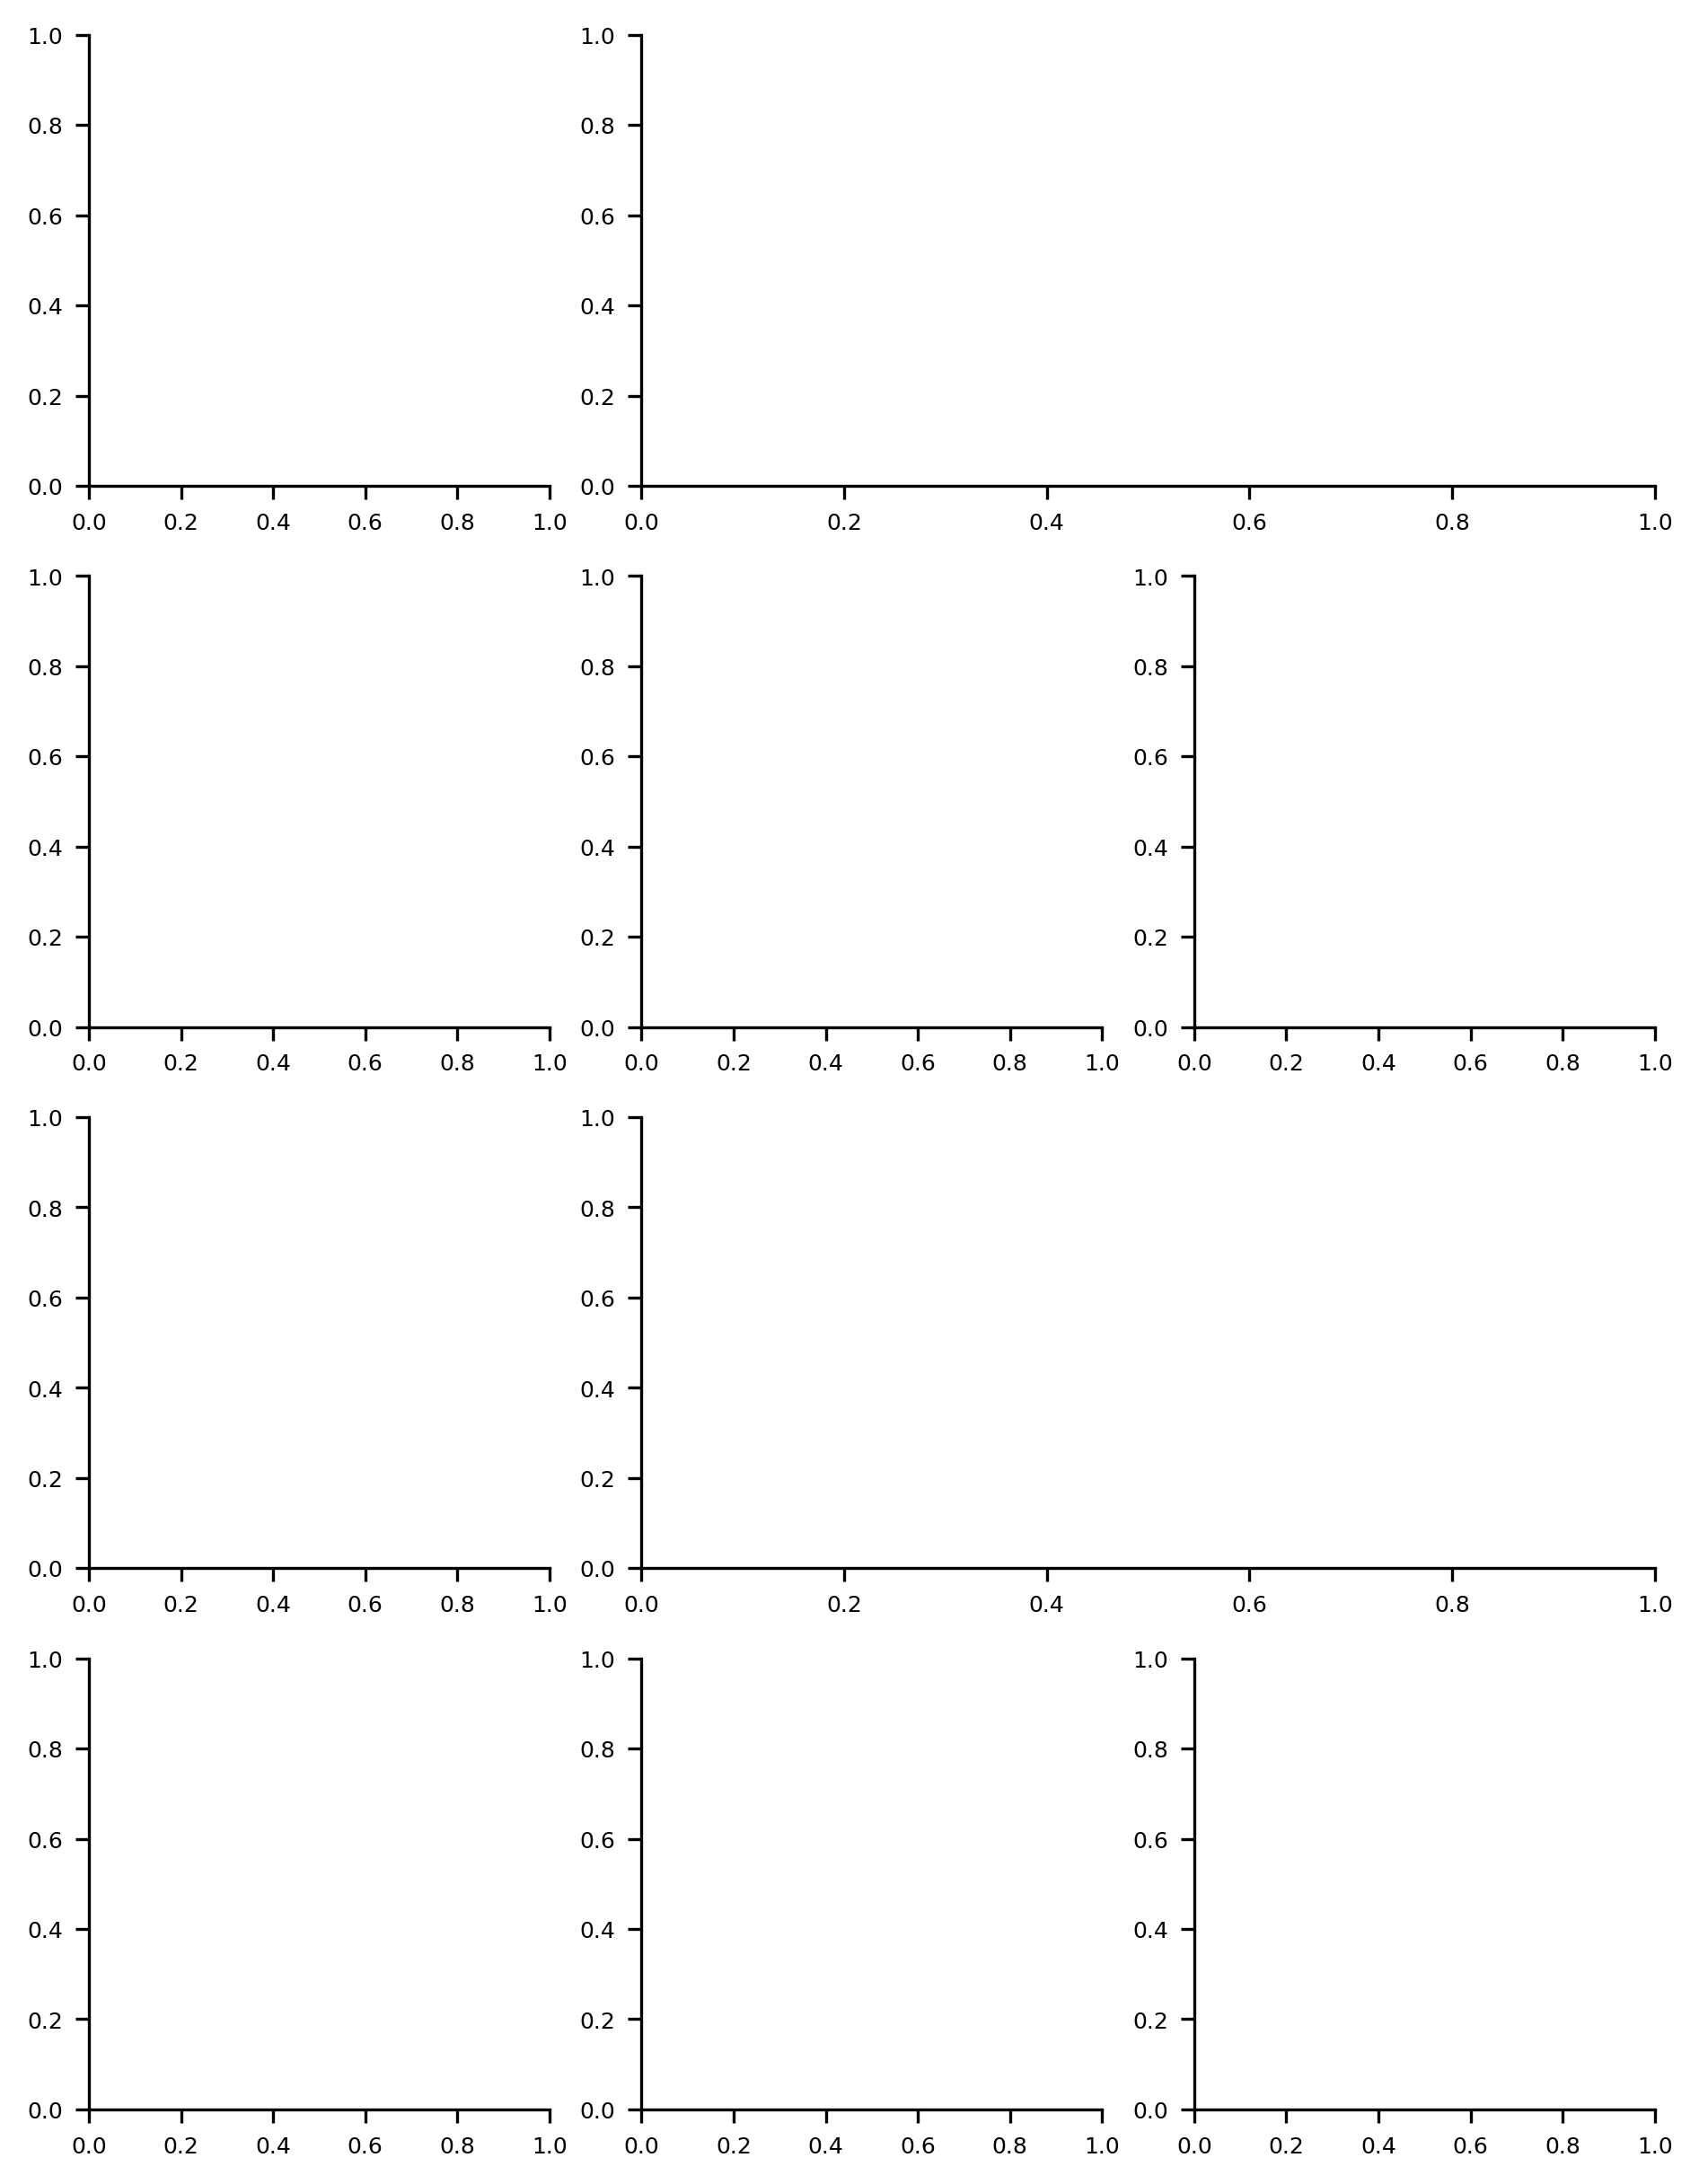

In [120]:
mosaic = [["A", "B", "B"], ["C", "D", "E"], ["F", "G", "G"], ["H", "I", "J"]]
fig, axs = plot_helpers.create_pannels(mosaic=mosaic, h_pad=0)

In [121]:
rpe_all_genes = pickle.load(
    open(os.path.join(DATA_FOLDER_ALL_GENES, "rpe_results.pkl"), "rb")
)
rpe_all_genes

{'library_size': array([9133, 8404, 8828, ..., 5195, 7878, 9967], dtype=uint64),
 'inferred_theta': array([-1.3392487, -0.7050874, -2.0906801, ..., -2.020346 , -2.1835725,
        -2.1161   ], dtype=float32),
 'histones_fraction': array([0.00043797, 0.00035697, 0.00101948, ..., 0.00076997, 0.00076161,
        0.00030099]),
 'cell_indices': array(['AAACCCACAAATTGGAx', 'AAACCCACAAGTAGTAx', 'AAACCCAGTCTGTGGCx', ...,
        'TTTGGTTTCTTTGATCx', 'TTTGTTGCACGGTGTCx', 'TTTGTTGTCCTACCACx'],
       dtype=object),
 'z_space': {'z_1': array([0.1529143 , 0.14705613, 0.12260033, ..., 0.09629886, 0.08904938,
         0.07637198], dtype=float32),
  'z_2': array([ 0.11510978,  0.07785028,  0.19553918, ..., -0.27156988,
         -0.2899404 , -0.34138876], dtype=float32)},
 'df_mean':        TRAF3IP3  AC005288.1       PIR  AL590101.1    PNLDC1       AK9  \
 0      0.002329    0.001619  0.218372    0.001018  0.000751  0.058965   
 1      0.002951    0.001970  0.206466    0.001387  0.000752  0.046572   


In [122]:
rpe = pickle.load(open(os.path.join(DATA_FOLDER, "res_low_genes.pkl"), "rb"))
rpe

{'two_genes_res': {'phases': tensor([-1.3531,  0.3833, -0.5748,  ..., -1.1657, -1.5388,  1.3815]),
  'gene_score':              peak_to_peak     phase  mean_expression     score
  CLSTN2           2.122831 -0.939521         0.018234  0.152343
  FAM72A           1.454658 -2.981179         0.002846  0.012188
  MZT1             1.252566 -2.862356         0.634779  2.221289
  AC007881.3       1.696063 -2.329638         0.000599  0.003265
  C4orf47          2.226986  0.431421         0.002610  0.024200
  ...                   ...       ...              ...       ...
  AL022098.1       2.061357 -2.585453         0.000461  0.003624
  ZNF141           0.909374  0.431421         0.011295  0.028042
  TMEM254-AS1      1.806491 -1.796922         0.000968  0.005894
  AC026461.3       1.698389 -2.862356         0.000925  0.005056
  AC015982.2       1.950016 -1.913607         0.017236  0.121146
  
  [2000 rows x 4 columns],
  'df_rhythmic':          CLSTN2    FAM72A      MZT1  AC007881.3   C4orf47  E

In [123]:
adata_RPE = anndata.read_h5ad(
    f"{SCRNASEQ_DATA_FOLDER}cellcycle_maxine/RPE_37C_Rep1_full.h5ad"
)
adata_RPE = anndata.concat(
    [
        adata_RPE,
        anndata.read_h5ad(
            f"{SCRNASEQ_DATA_FOLDER}cellcycle_maxine/RPE_37C_Rep2_full.h5ad"
        ),
    ]
)
adata_RPE.obs_names_make_unique()
adata_RPE = adata_RPE[rpe_all_genes["cell_indices"], :]

/home/maxine/miniconda3/envs/VAE_Fourrier_Env/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [124]:
adata_RPE.obs["batch"] = (
    (pd.factorize(adata_RPE.obs["batch"])[0] + 1).astype("str").copy()
)

/tmp/ipykernel_1463483/3115089976.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_RPE.obs["batch"] = (


In [125]:
def circular_correlation(alpha, beta):
    """
    Compute the circular-circular correlation coefficient between two angle vectors.

    Parameters
    ----------
    alpha : array-like
        First set of angles in radians.
    beta : array-like
        Second set of angles in radians.

    Returns
    -------
    float
        Circular correlation coefficient (range: -1 to 1).
    """
    alpha = np.asarray(alpha)
    beta = np.asarray(beta)

    # Mean directions
    alpha_bar = np.arctan2(np.sum(np.sin(alpha)), np.sum(np.cos(alpha)))
    beta_bar = np.arctan2(np.sum(np.sin(beta)), np.sum(np.cos(beta)))

    # Deviations
    sin_a = np.sin(alpha - alpha_bar)
    sin_b = np.sin(beta - beta_bar)

    # Numerator and denominator
    num = np.sum(sin_a * sin_b)
    den = np.sqrt(np.sum(sin_a**2) * np.sum(sin_b**2))

    if den == 0:
        return np.nan  # Undefined correlation

    return num / den

In [126]:
def plot_circ_corr(ax, inferred_theta, true_phases, title, title_gt):
    plotting.plot_phase_accuracy(
        inferred_theta,
        true_phases,
        ax=ax,
        title=title,
        title_gt=title_gt,
    )
    circ_corr = np.abs(circular_correlation(alpha=inferred_theta, beta=-true_phases))
    ax.annotate(
        f"Circ. Corr.: {circ_corr:.2f}",
        xy=(0.05, 0.9),
        xycoords="axes fraction",
        fontsize=10,
    )


inferred_theta = rpe["two_genes_res"]["phases"].detach().cpu().numpy().flatten()
inferred_theta = utils.align_phases(inferred_theta, rpe_all_genes["inferred_theta"])

plot_circ_corr(
    axs["A"],
    rpe_all_genes["inferred_theta"],
    inferred_theta,
    "2 Genes",
    "98 Genes Phase",
)

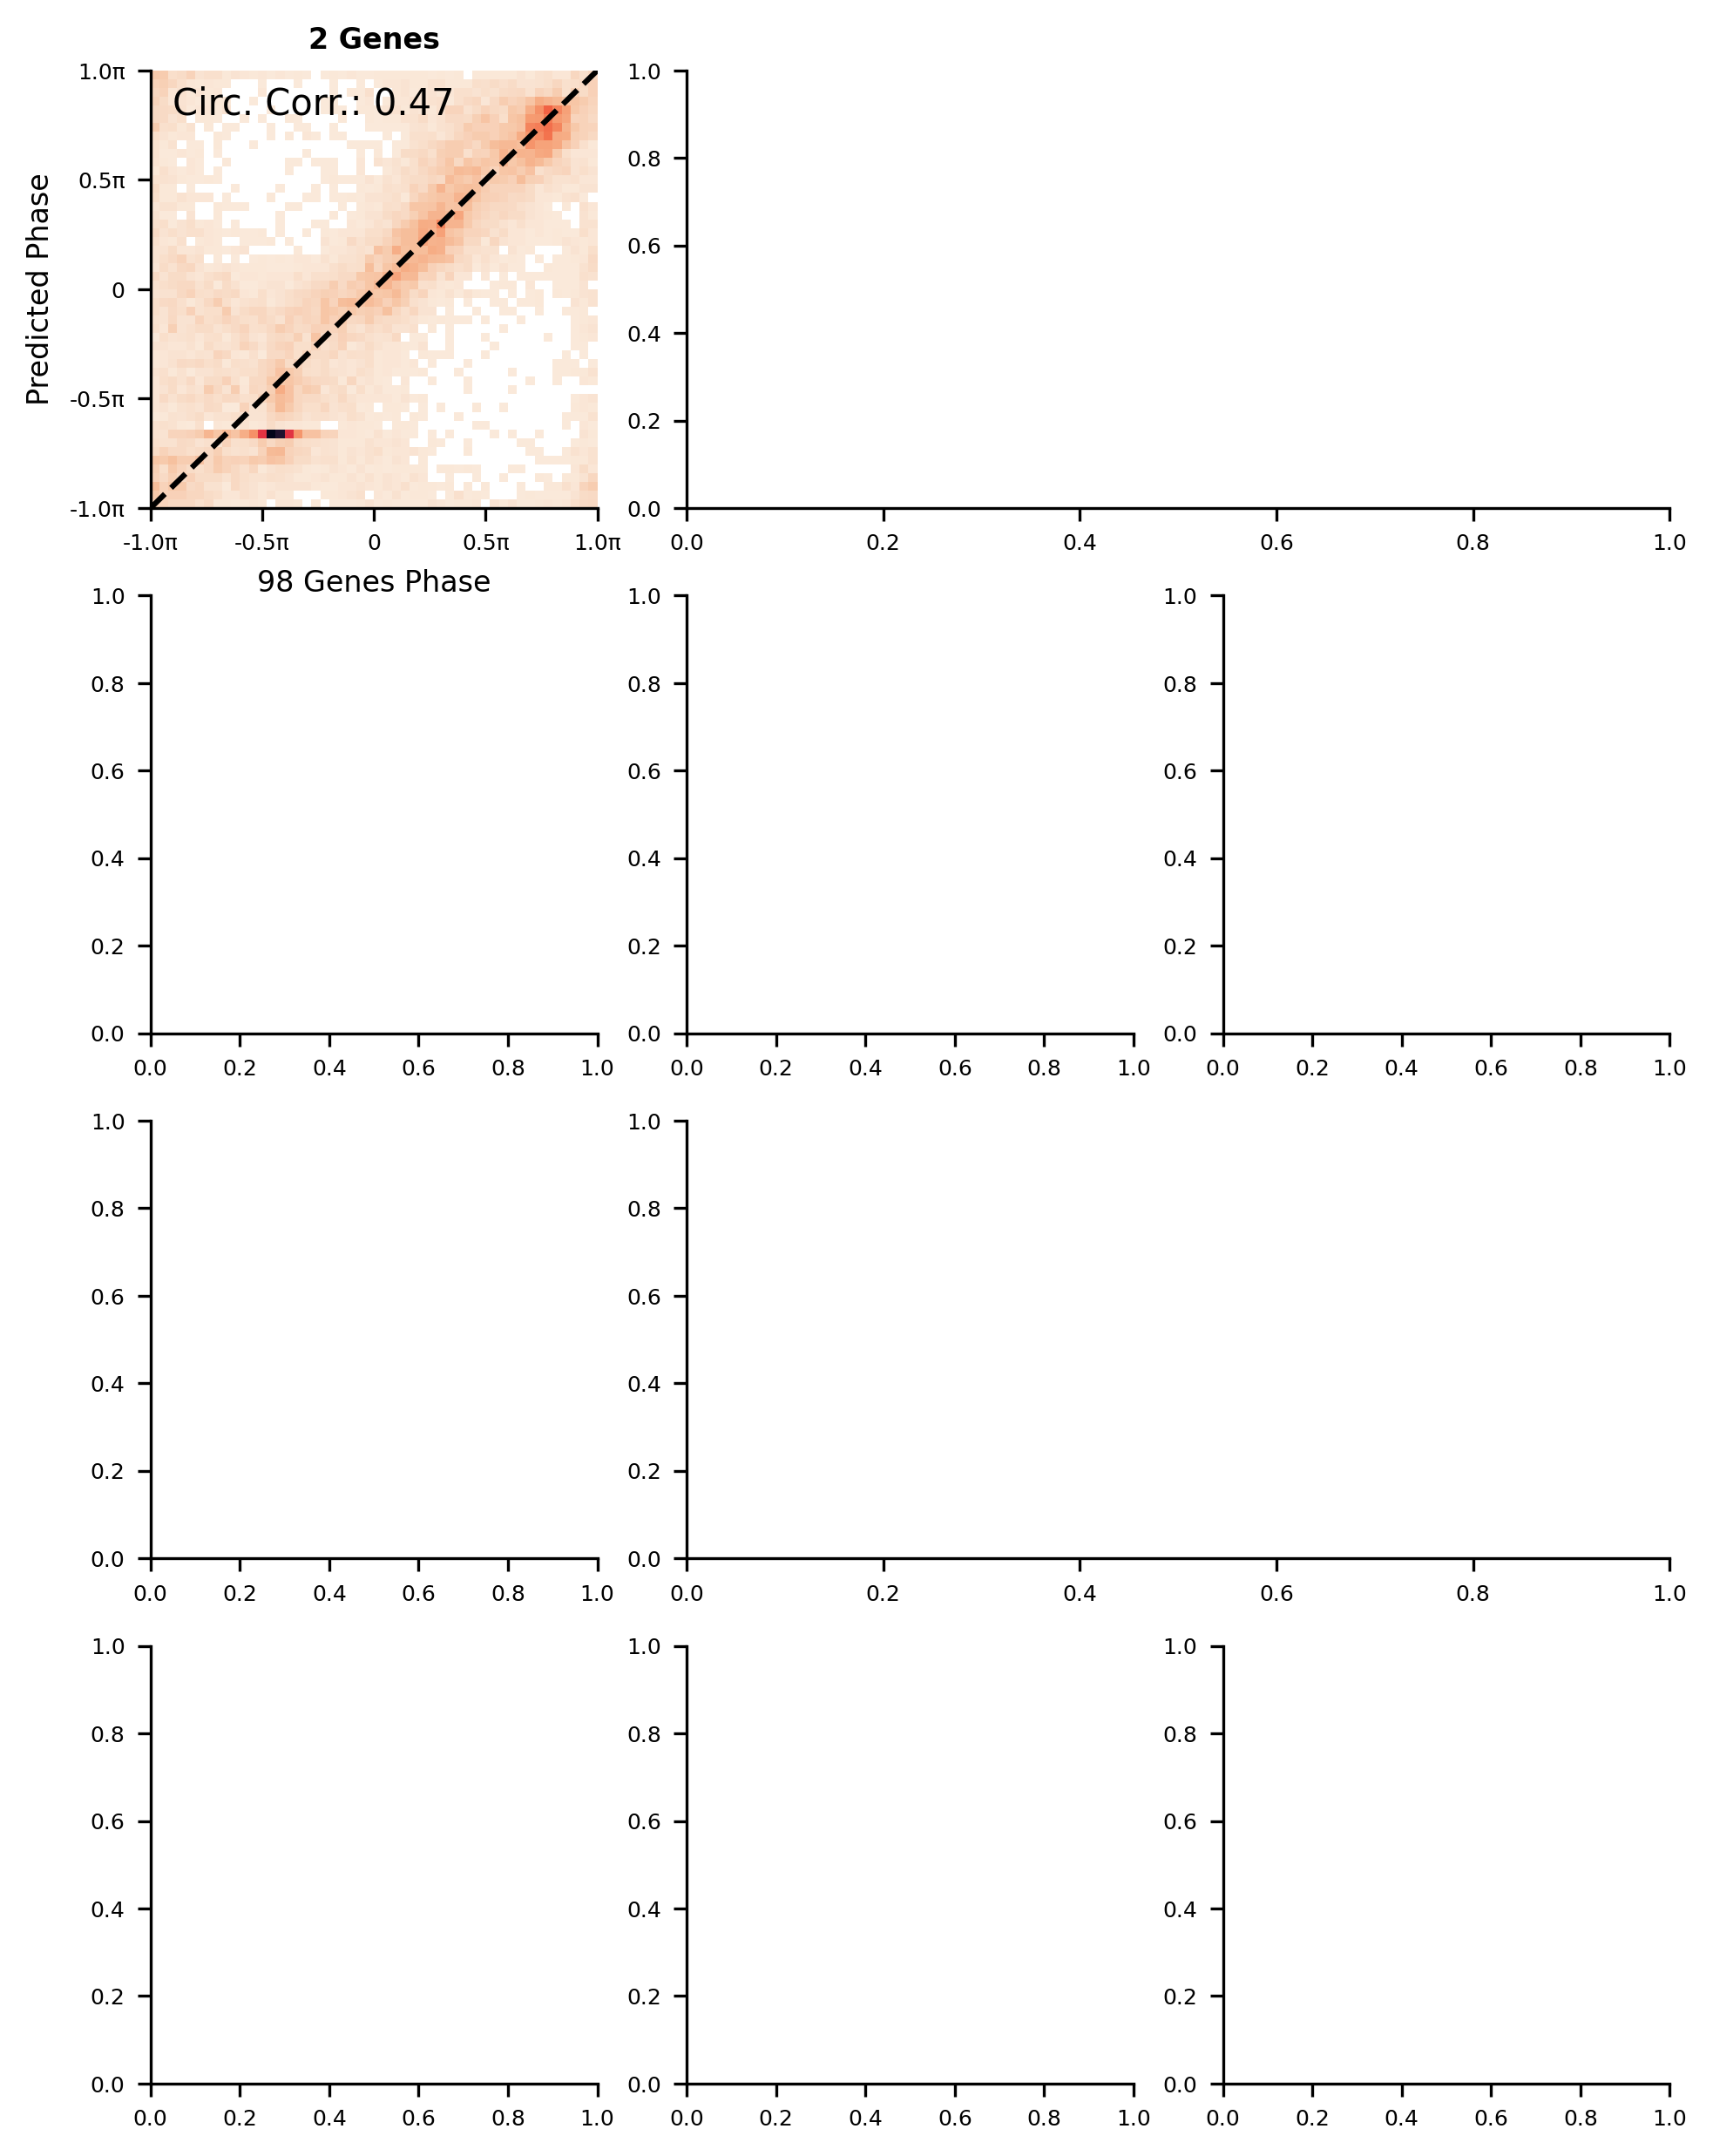

In [127]:
fig

In [128]:
def get_gene_fractions(gene_name, adata, layer="spliced"):
    library_size = adata.layers[layer].sum(axis=1)
    library_size = np.array(library_size).flatten()
    gene_fractions = (
        adata[:, gene_name].layers[layer].toarray().flatten() / library_size
    )
    return gene_fractions


def plot_gene_profiles(
    gene_names,
    adata,
    inferred_phase,
    axs,
    position,
    GT_phase=None,
    layer="spliced",
    hue=None,
    phase_label="Inferred",
):
    axs = plot_helpers.replace_mosaic_cell_with_grid(
        fig, axs, label=position, nrows=1, ncols=len(gene_names)
    )
    for i in range(len(gene_names)):
        gene_name = gene_names[i]
        gene_fractions = get_gene_fractions(gene_name, adata, layer=layer)
        _, axs[position][i] = plotting.modify_axis_labels(
            ax=axs[position][i], axis="x", step=0.5
        )
        plotting.plot_smoothed_profiles(
            inferred_phase,
            np.log(gene_fractions * 1e4 + 1),
            ax=axs[position][i],
            nbins=20,
            xlabel="Inferred Phase",
            ylabel=f"Normalized Counts (log)" if i == 0 else None,
            title=f"",
            label=(
                phase_label
                if (i == len(gene_names) - 1 and GT_phase is not None)
                else None
            ),
            legend=i == len(gene_names) - 1,
            hue=hue,
        )
        if GT_phase is not None:
            plotting.plot_smoothed_profiles(
                GT_phase,
                np.log(gene_fractions * 1e4 + 1),
                ax=axs[position][i],
                nbins=20,
                xlabel="Inferred Phase",
                ylabel=f"Normalized Counts (log)" if i == 0 else None,
                title=f"{gene_name} Profile",
                label="98 Genes" if i == len(gene_names) - 1 else None,
            )
        axs[position][i].set_title(gene_name, fontweight="bold", style="italic")


plot_gene_profiles(
    ["MCM6", "PCNA", "TOP2A"],
    adata_RPE,
    inferred_theta,
    axs,
    position="B",
    GT_phase=rpe_all_genes["inferred_theta"],
    layer="spliced",
    phase_label="2 Genes",
)

In [129]:
shift = utils.get_best_shift_direction(
    rpe["two_genes_res"]["phases"].detach().cpu().numpy().flatten(),
    rpe_all_genes["inferred_theta"],
)
plot_helpers.make_polar(axs=axs, label="C")
plotting.plot_cell_cycle(
    rpe["two_genes_res"]["df_rhythmic"],
    shift=shift["shift"],
    direction=shift["direction"],
    ax=axs["C"],
)

/home/maxine/Documents/paychere/cell_cycle_VAE_Fourrier_model/src/CoPhaser/plotting.py:232: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


In [130]:
ax = axs["D"]
x = plotting.modify_axis_labels(ax=ax, axis="x", step=0.5)[0]
plotting.plot_smoothed_profiles(
    inferred_theta,
    rpe_all_genes["library_size"],
    ax=ax,
    nbins=20,
    xlabel="Inferred Phase",
    ylabel="Mean #UMI",
    title="#UMI vs Inferred Phase",
    hue=adata_RPE.obs["batch"],
    cmap="Set2",
)

In [131]:
ax = axs["E"]
plotting.modify_axis_labels(ax=ax, axis="x", step=0.5)
plotting.plot_smoothed_profiles(
    inferred_theta,
    get_gene_fractions("HIST1H4C", adata_RPE, layer="spliced") * 1e4,
    ax=ax,
    xlabel="Phase",
    ylabel="Normalized Counts",
    title="",
    hue=adata_RPE.obs["batch"],
    cmap="Set2",
)
ax.set_title("H4C3", fontweight="bold", style="italic")

Text(0.5, 1.0, 'H4C3')

In [132]:
inferred_theta = rpe["twenty_genes_res"]["phases"].detach().cpu().numpy().flatten()
inferred_theta = utils.align_phases(inferred_theta, rpe_all_genes["inferred_theta"])

In [133]:
plot_circ_corr(
    axs["F"],
    rpe_all_genes["inferred_theta"],
    inferred_theta,
    "20 Genes",
    "98 Genes Phase",
)

In [134]:
plot_gene_profiles(
    ["MCM6", "PCNA", "TOP2A"],
    adata_RPE,
    inferred_theta,
    axs,
    position="G",
    GT_phase=rpe_all_genes["inferred_theta"],
    layer="spliced",
    phase_label="20 Genes",
)

In [135]:
shift = utils.get_best_shift_direction(
    rpe["twenty_genes_res"]["phases"].detach().cpu().numpy().flatten(),
    rpe_all_genes["inferred_theta"],
)
plot_helpers.make_polar(axs=axs, label="H")
plotting.plot_cell_cycle(
    rpe["twenty_genes_res"]["df_rhythmic"],
    shift=shift["shift"],
    direction=shift["direction"],
    ax=axs["H"],
)

/home/maxine/Documents/paychere/cell_cycle_VAE_Fourrier_model/src/CoPhaser/plotting.py:232: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


<Axes: >

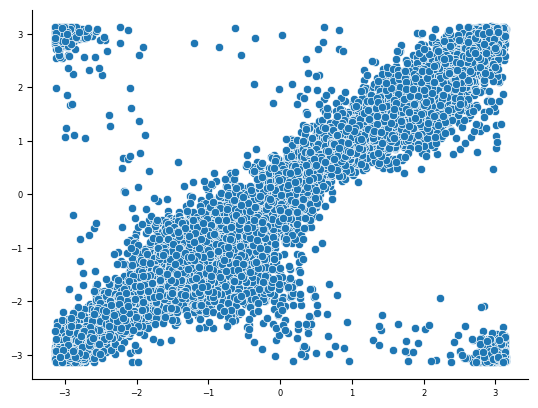

In [136]:
sns.scatterplot(
    x=rpe_all_genes["inferred_theta"],
    y=utils.normalize_angles(
        rpe["twenty_genes_res"]["phases"].detach().cpu().numpy().flatten()
        * shift["direction"]
        - shift["shift"]
    ),
)

In [137]:
ax = axs["I"]
x = plotting.modify_axis_labels(ax=ax, axis="x", step=0.5)[0]
plotting.plot_smoothed_profiles(
    inferred_theta,
    rpe_all_genes["library_size"],
    ax=ax,
    nbins=20,
    xlabel="Inferred Phase",
    ylabel="Mean #UMI",
    title="#UMI vs Inferred Phase",
    hue=adata_RPE.obs["batch"],
    cmap="Set2",
)

In [138]:
ax = axs["J"]
plotting.modify_axis_labels(ax=ax, axis="x", step=0.5)
plotting.plot_smoothed_profiles(
    inferred_theta,
    get_gene_fractions("HIST1H4C", adata_RPE, layer="spliced") * 1e4,
    ax=ax,
    xlabel="Phase",
    ylabel="Normalized Counts",
    title="",
    hue=adata_RPE.obs["batch"],
    cmap="Set2",
)
ax.set_title("H4C3", fontweight="bold", style="italic")
ax.set_ylim(bottom=0)

(0.0, 105.28465619911182)

/home/maxine/Documents/paychere/cell_cycle_VAE_Fourrier_model/paper/code/figure_S3/../set_up/plot_helpers.py:89: UserWarning: Rasterization of 'Line2D(_child1)' will be ignored
  artist.set_rasterized(True)


Figure saved to: /home/maxine/Documents/paychere/cell_cycle_VAE_Fourrier_model/paper/figures/figure_S3_low_genes.svg


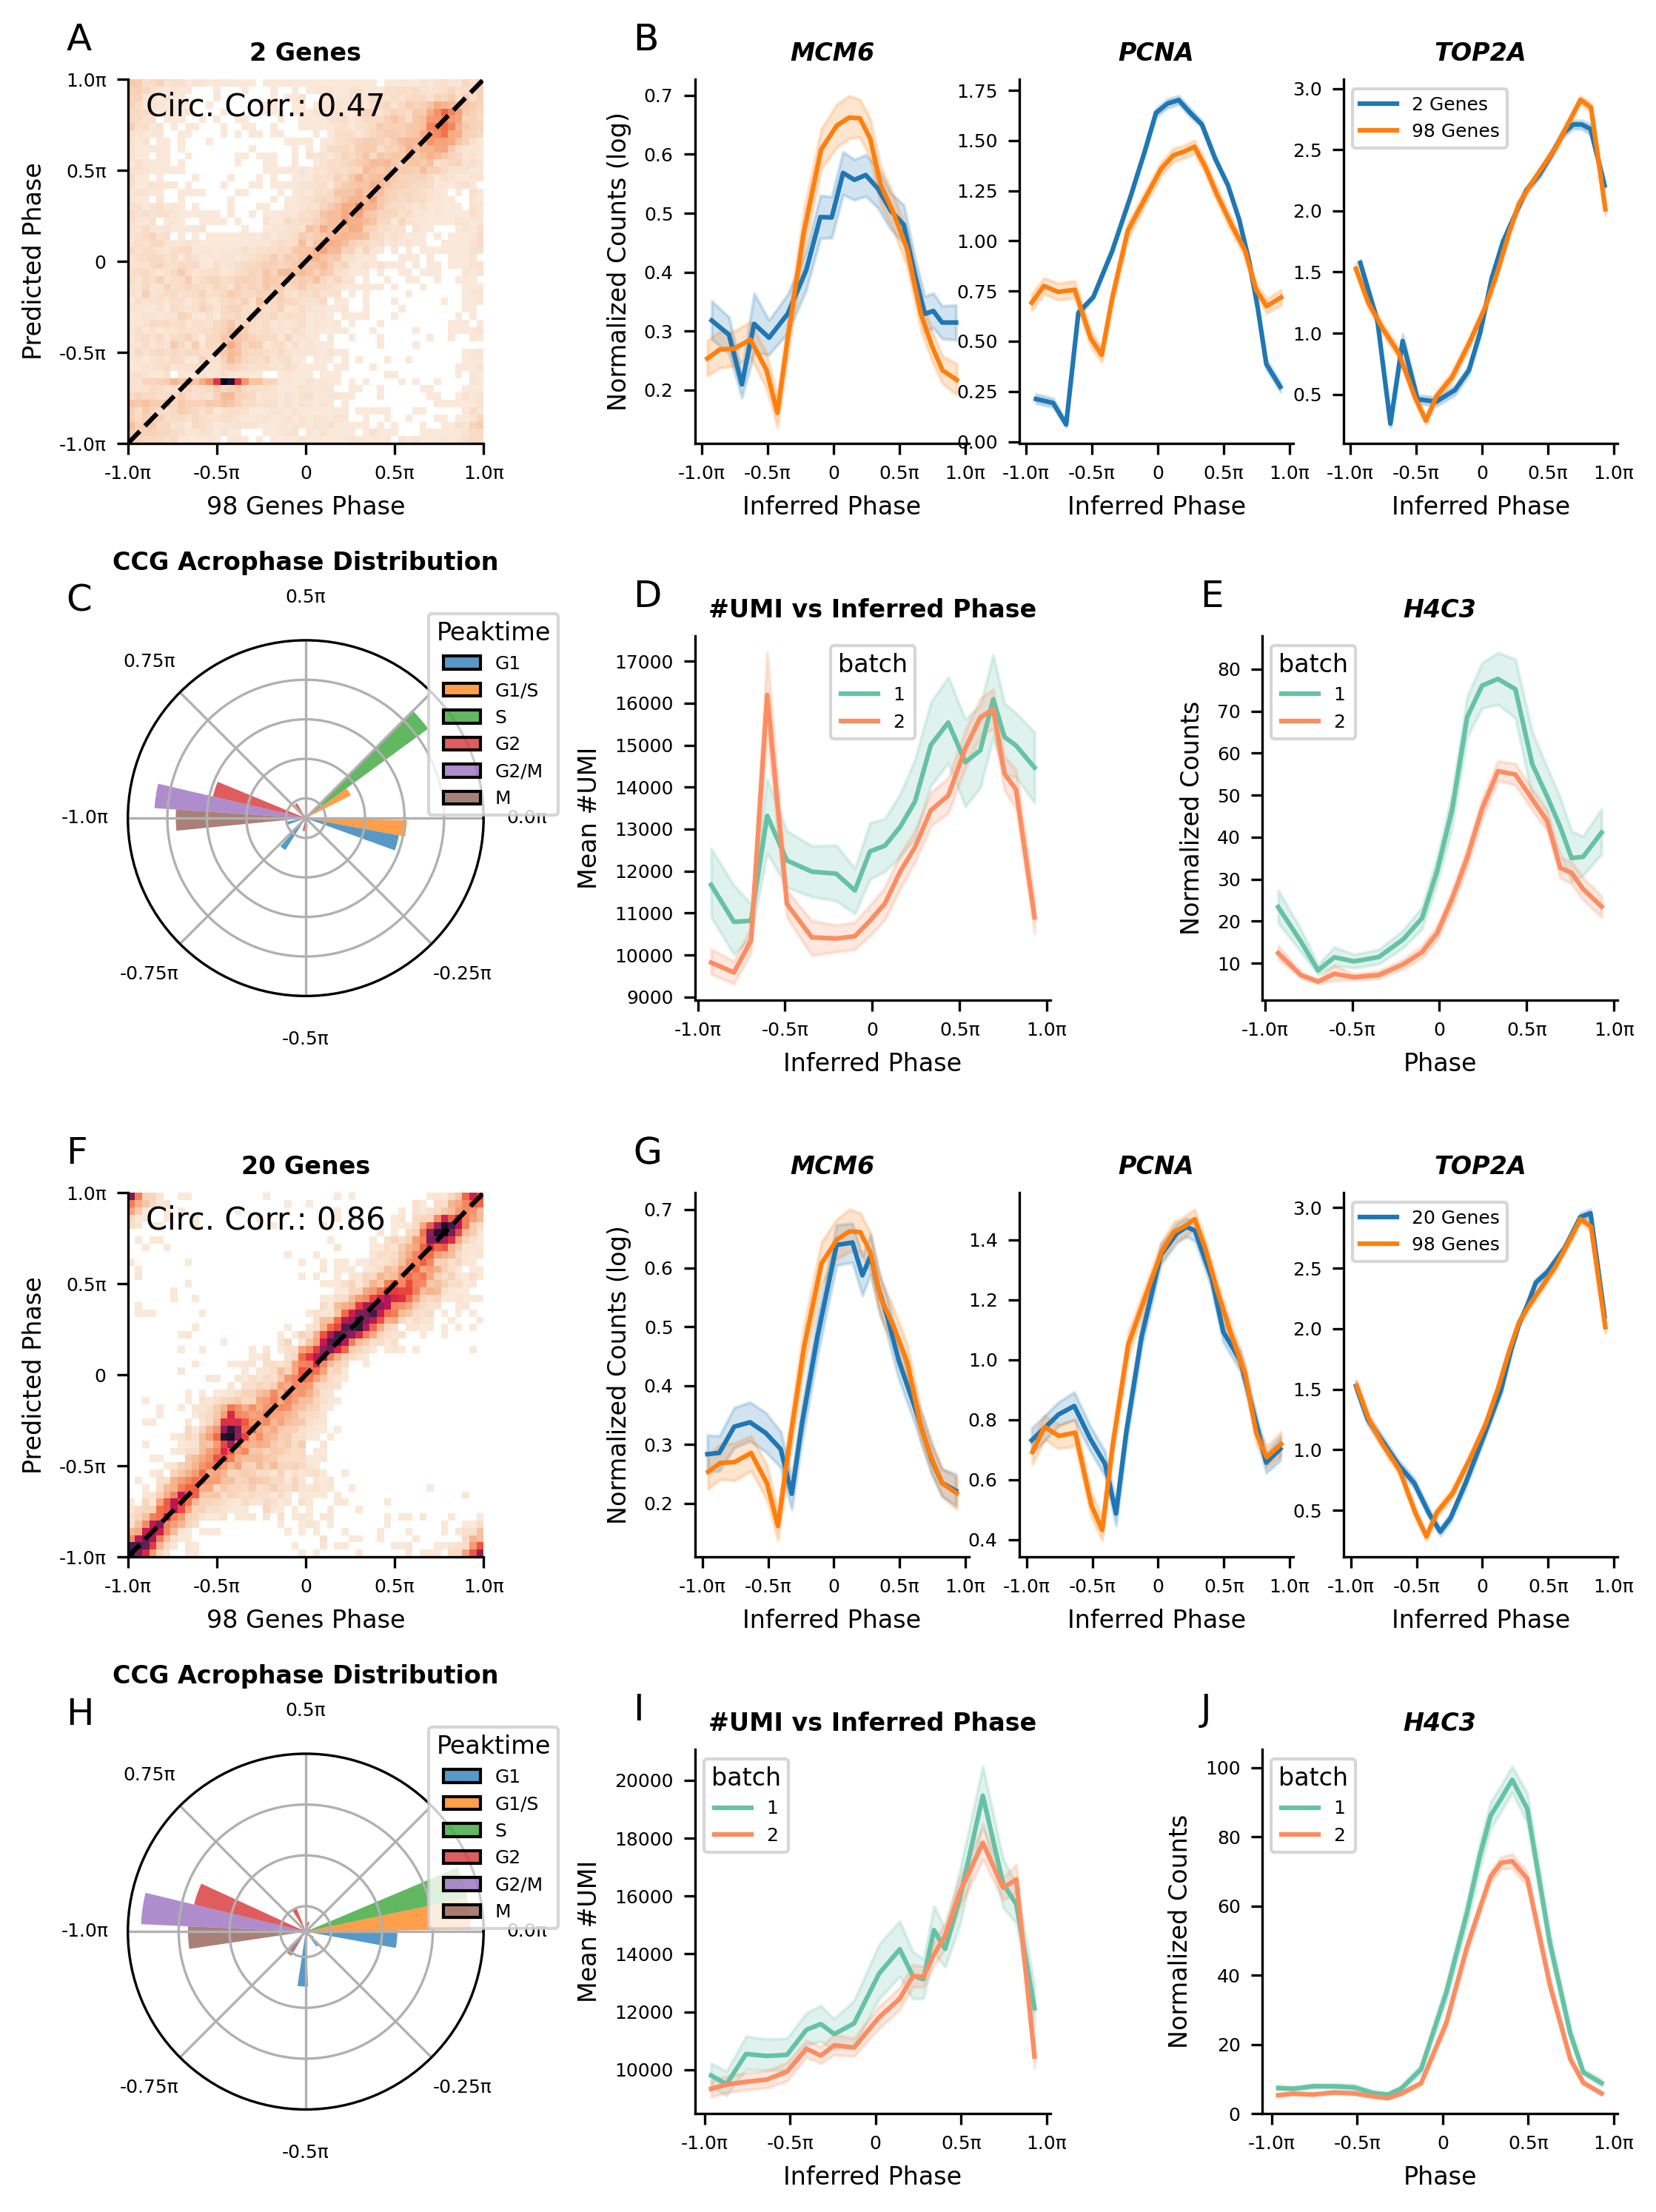

In [139]:
plot_helpers.label_panels_mosaic(fig, axs, mosaic)
plot_helpers.save_figure(fig, axs, "figure_S3_low_genes")